In [37]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set global float display format to two decimal places with commas
pd.options.display.float_format = '{:.2f}'.format

In [38]:
# Get the root of the project (automatically resolves relative to this script)
PROJECT_ROOT = Path().resolve().parent

# Define data paths
RAW_DATA_PATH = PROJECT_ROOT / "data" / "raw" / "yellow_tripdata_2023-01.parquet"

# Read data
df = pd.read_parquet(RAW_DATA_PATH)

In [39]:
# Check the size of the dataset
df.shape

(3066766, 19)

In [40]:
# Check the first five rows
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.00,0.97,1.00,N,161,141,2,9.30,1.00,0.50,0.00,0.00,1.00,14.30,2.50,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.00,1.10,1.00,N,43,237,1,7.90,1.00,0.50,4.00,0.00,1.00,16.90,2.50,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.00,2.51,1.00,N,48,238,1,14.90,1.00,0.50,15.00,0.00,1.00,34.90,2.50,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.00,1.90,1.00,N,138,7,1,12.10,7.25,0.50,0.00,0.00,1.00,20.85,0.00,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.00,1.43,1.00,N,107,79,1,11.40,1.00,0.50,3.28,0.00,1.00,19.68,2.50,0.00


In [41]:
# Check column data types
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [42]:
# Check the percentage of missing values (top 10)
df.isnull().mean().sort_values(ascending=False).head(10)

airport_fee             0.02
congestion_surcharge    0.02
passenger_count         0.02
RatecodeID              0.02
store_and_fwd_flag      0.02
extra                   0.00
total_amount            0.00
improvement_surcharge   0.00
tolls_amount            0.00
tip_amount              0.00
dtype: float64

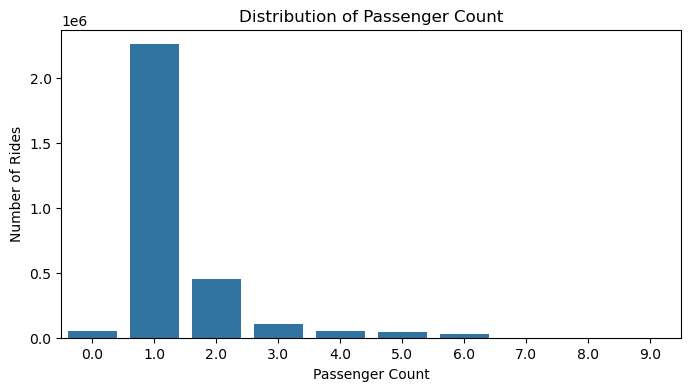

In [43]:
# Distribution of passenger count
plt.figure(figsize=(8, 4))
sns.countplot(x="passenger_count", data=df)
plt.title("Distribution of Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Number of Rides")
plt.show()

In [44]:
# Inspect distribution percentiles
df["trip_distance"].describe(percentiles=[0.90, 0.95, 0.99])

count   3066766.00
mean          3.85
std         249.58
min           0.00
50%           1.80
90%           8.63
95%          14.32
99%          20.06
max      258928.15
Name: trip_distance, dtype: float64

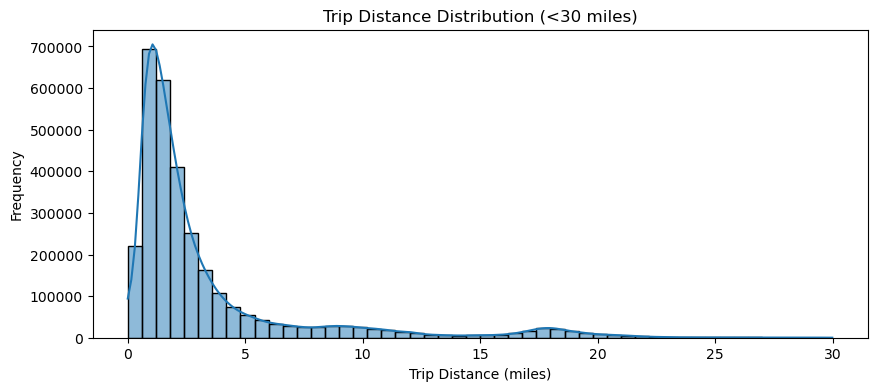

In [54]:
# Remove outliers for better visualization
df_filtered = df[df["trip_distance"] < 30]

plt.figure(figsize=(10, 4))
sns.histplot(df_filtered["trip_distance"], bins=50, kde=True)
plt.title("Trip Distance Distribution (<30 miles)")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Frequency")
plt.show()

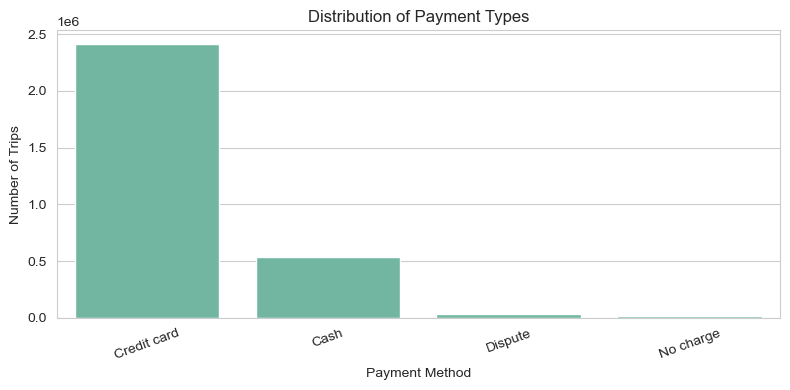

In [62]:
# Payment type frequency
# Define mapping frequency
payment_map = {
    1: "Credit card",
    2: "Cash",
    3: "No charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided trip"
}

# Create a new column with readable labels
df["payment_type_label"] = df["payment_type"].map(payment_map)

# Plot using the new column
plt.figure(figsize=(8, 4))
sns.countplot(x="payment_type_label", data=df, order=df["payment_type_label"].value_counts().index)
plt.title("Distribution of Payment Types")
plt.xlabel("Payment Method")
plt.ylabel("Number of Trips")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [72]:
# Trip duration in minutes
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
df["trip_duration_min"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60

In [74]:
# Inspect distribution percentiles
df["trip_duration_min"].describe(percentiles=[0.90, 0.95, 0.99])

count   3066766.00
mean         15.67
std          42.59
min         -29.20
50%          11.52
90%          27.94
95%          36.47
99%          57.25
max       10029.18
Name: trip_duration_min, dtype: float64

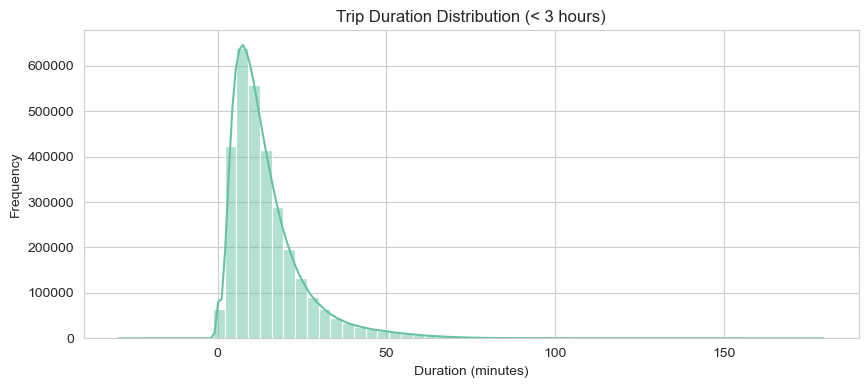

In [78]:
# Filter trips longer than 3 hours
df_filtered = df[df["trip_duration_min"] < 180]

plt.figure(figsize=(10, 4))
sns.histplot(df_filtered["trip_duration_min"], bins=60, kde=True)
plt.title("Trip Duration Distribution (< 3 hours)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.show()

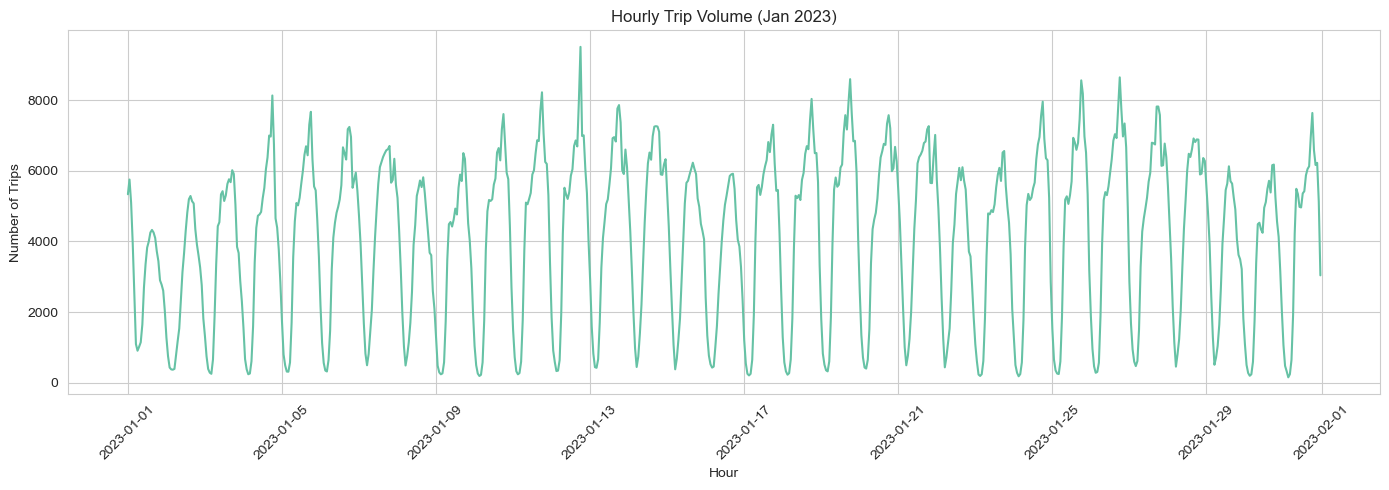

In [106]:
# Filter to only include trips in January 2023
df = df[
    (df["tpep_pickup_datetime"] >= "2023-01-01") &
    (df["tpep_pickup_datetime"] < "2023-02-01")
].copy()

# Hours trip volume (based on pickup time)
df["pickup_hour"] = df["tpep_pickup_datetime"].dt.floor("h")
trip_hourly = df.groupby("pickup_hour").size().reset_index(name="trip_count")

# Ensure the pickup_hour column is datetime type (for proper x-axis formatting)
trip_hourly["pickup_hour"] = pd.to_datetime(trip_hourly["pickup_hour"])

plt.figure(figsize=(14, 5))
sns.lineplot(data=trip_hourly, x="pickup_hour", y="trip_count")
plt.title("Hourly Trip Volume (Jan 2023)")
plt.xlabel("Hour")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()